**Table of contents**<a id='toc0_'></a>    
- [Import Libs and Dataset](#toc1_1_)    
- [I. Data validation](#toc2_)    
    - [Checking duplication](#toc2_1_1_)    
    - [Handling structural errors](#toc2_1_2_)    
    - [Checking outliers](#toc2_1_3_)    
    - [Handling Missing Data](#toc2_1_4_)    
      - [Checking Missing Data](#toc2_1_4_1_)    
      - [Missing Data Handling with Regression Imputation | Linear Interpolation](#toc2_1_4_2_)    
        - [Grouping data](#toc2_1_4_2_1_)    
        - [Checking for Statistical Significant Linear Relationship and Correlation Coefficient](#toc2_1_4_2_2_)    
        - [Data Imputation with Linear Regression](#toc2_1_4_2_3_)    
- [II. Exploratory Analysis](#toc3_)    
    - [How many customers were there for each approach?](#toc3_1_1_)    
    - [What does the spread of the revenue look like overall? And for each method?](#toc3_1_2_)    
    - [Was there any difference in revenue over time for each of the methods?](#toc3_1_3_)    
      - [Conclusion](#toc3_1_3_1_)    
- [III. Prediction Analysis](#toc4_)    
    - [Predicted Total Revenue](#toc4_1_1_)    
    - [Predicted Cumulative revenue](#toc4_1_2_)    
    - [Conclusion](#toc4_1_3_)    
- [IV. New Metrics Recommendation](#toc5_)    
    - [ARPU & Revenue Growth Rate](#toc5_1_1_)    
    - [Predicted ARPU & Revenue Growth Rate](#toc5_1_2_)    
        - [ARPU](#toc5_1_2_1_1_)    
        - [Growth Rate](#toc5_1_2_1_2_)    
      - [Conclusion](#toc5_1_2_2_)    
- [V. Summary & Recommendation](#toc6_)    
  - [Recommendation](#toc6_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Import Libs and Dataset](#toc0_)

In [1]:
# import libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

from scipy.stats import spearmanr

# show all output in Notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# suppress SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

# Show all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# dataset
product_sales = pd.read_csv('product_sales.csv')

In [ ]:
product_sales.head()

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state
0,2,Email,2e72d641-95ac-497b-bbf8-4861764a7097,10,NaN,0,24,Arizona
1,6,Email + Call,3998a98d-70f5-44f7-942e-789bb8ad2fe7,15,225.47,1,28,Kansas
2,5,Call,d1de9884-8059-4065-b10f-86eef57e4a44,11,52.55,6,26,Wisconsin
3,4,Email,78aa75a4-ffeb-4817-b1d0-2f030783c5d7,11,NaN,3,25,Indiana
4,3,Email,10e6d446-10a5-42e5-8210-1b5438f70922,9,90.49,0,28,Illinois


# <a id='toc2_'></a>[I. Data validation](#toc0_)
- Describe validation and cleaning steps for every column in the data 

### <a id='toc2_1_1_'></a>[Checking duplication](#toc0_)

In [4]:
product_sales[product_sales.duplicated()]

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state


There are no duplicated rows in this dataset so we will move on checking if there are any structural errors in this dataset.

### <a id='toc2_1_2_'></a>[Handling structural errors](#toc0_)

In [5]:
# checking number of unique values in each columns of the table
for column in product_sales.columns:
    print(f'Number of unique values in {column}: {product_sales[column].nunique()}')

Number of unique values in week: 6
Number of unique values in sales_method: 5
Number of unique values in customer_id: 15000
Number of unique values in nb_sold: 10
Number of unique values in revenue: 6743
Number of unique values in years_as_customer: 42
Number of unique values in nb_site_visits: 27
Number of unique values in state: 50


As we already know there are only 3 new product sales methods which have been introduced in the email (Email, Call, Email and call). So 5 unique values in the sales_method column is rather suspicious. We will look further into that column and perform Fixing structural errors if necessary.

In [6]:
for i in product_sales.sales_method.unique():
    i

'Email'

'Email + Call'

'Call'

'em + call'

'email'

In [7]:
product_sales.groupby('sales_method')['customer_id'].count()

sales_method
Call            4962
Email           7456
Email + Call    2549
em + call         23
email             10
Name: customer_id, dtype: int64

This is structural errors when data shows strange naming conventions, typos, or incorrect capitalization. These inconsistencies can cause mislabeled categories or classes so in this case we going to fix it by categorizing sales method again into 3 sales methods based on the count on each sales method

In [8]:
product_sales.sales_method = product_sales.sales_method.str.replace('em + call', 'Email + Call')
product_sales.sales_method = product_sales.sales_method.str.replace('email', 'Email')

In [9]:
for i in product_sales.sales_method.unique():
    i

'Email'

'Email + Call'

'Call'

In [ ]:
product_sales.groupby('sales_method')['customer_id'].count()

sales_method
Call            4962
Email           7466
Email + Call    2572
Name: customer_id, dtype: int64

### <a id='toc2_1_3_'></a>[Checking outliers](#toc0_)

<Figure size 1500x1300 with 0 Axes>

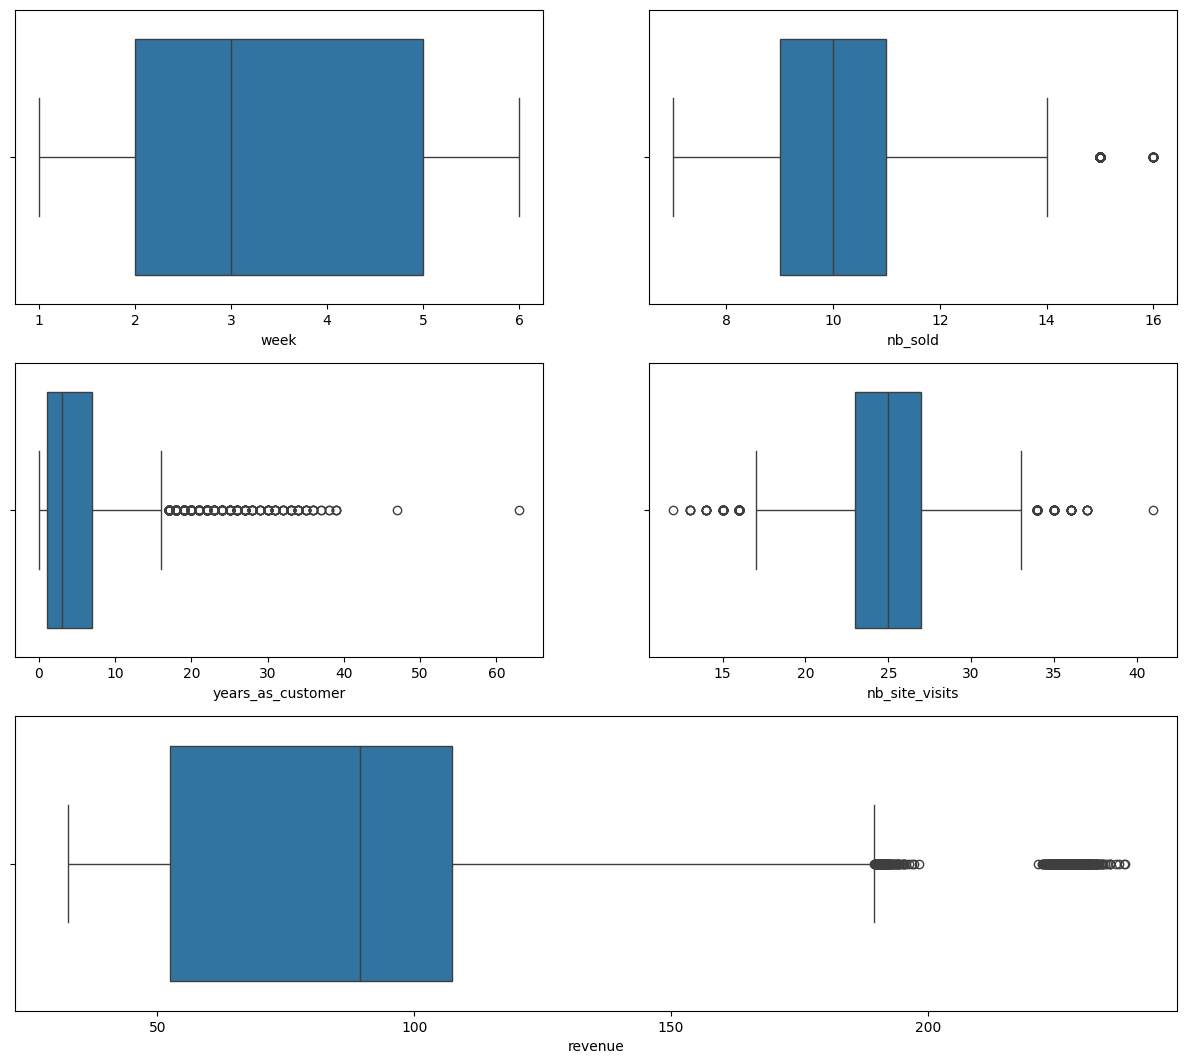

In [11]:
# Create 2x2 sub plots
gs = gridspec.GridSpec(3, 2)

# Create a figure
plt.figure(figsize=(15,13))

# add axes_1 row 0, col 0
ax1 = plt.subplot(gs[0, 0]) 
ax1 = sns.boxplot(
    data=product_sales.week
    ,orient='h'
)

# add axes_2 row 0, col 1
ax2 = plt.subplot(gs[0, 1]) 
ax2 = sns.boxplot(
    data=product_sales.nb_sold
    ,orient='h'
)
# add axes_3 row 1, col 0
ax3 = plt.subplot(gs[1, 0]) 
ax3 = sns.boxplot(
    data=product_sales.years_as_customer
    ,orient='h'
)

# add axes_4 row 1, col 1
ax4 = plt.subplot(gs[1, 1]) 
ax4 = sns.boxplot(
    data=product_sales.nb_site_visits
    ,orient='h'
)

# add axes_5 row 2, col 0
ax4 = plt.subplot(gs[2, :]) 
ax4 = sns.boxplot(
    data=product_sales.revenue
    ,orient='h'
)

# display plot
plt.show()

Pens and Printers was founded in 1984 and today is 2024, so anyone has more than 40 years as customer is measurement errors, data entry or processing errors so they should be remove from our data, the other outliers should be true outliers representing natural variations in the population, and they should be left as is in our dataset.

In [ ]:
error = product_sales['years_as_customer'] > 40
product_sales = product_sales[~error]

### <a id='toc2_1_4_'></a>[Handling Missing Data](#toc0_)

#### <a id='toc2_1_4_1_'></a>[Checking Missing Data](#toc0_)

In [13]:
# show number of nan value of all columns
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(product_sales.isna().sum())

week                    0
sales_method            0
customer_id             0
nb_sold                 0
revenue              1074
years_as_customer       0
nb_site_visits          0
state                   0
dtype: int64

The revenue col is the only column with missing data so we will focus on this matter first on revenue column. There are 2 ways:
- Drop missing data value if the number of missing value in the variable is less than 5% of the dataset size
- Imputation when otherwise the number of missing value in the variable is more than 5% 

In [14]:
# First we calculate our missing values threshold
threshold = 0.05 * len(product_sales)

# Then we compare the number of missing data with the threshold
if product_sales.revenue.isna().sum() < threshold:
    print('We will drop the missing data')
else:
    print('The number of missing data is higher than 5%, we will perform Data Imputation')

The number of missing data is higher than 5%, we will perform Data Imputation


First we have to explore the data a little bit to decide which Imputation Method will be applied because there many methods depending on the attribute, distribution, relationship of the data 

In [15]:
no_missing_data = product_sales[~product_sales['revenue'].isna()]
no_missing_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13924 entries, 1 to 14998
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   week               13924 non-null  int64  
 1   sales_method       13924 non-null  object 
 2   customer_id        13924 non-null  object 
 3   nb_sold            13924 non-null  int64  
 4   revenue            13924 non-null  float64
 5   years_as_customer  13924 non-null  int64  
 6   nb_site_visits     13924 non-null  int64  
 7   state              13924 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 979.0+ KB


<Figure size 1500x600 with 0 Axes>

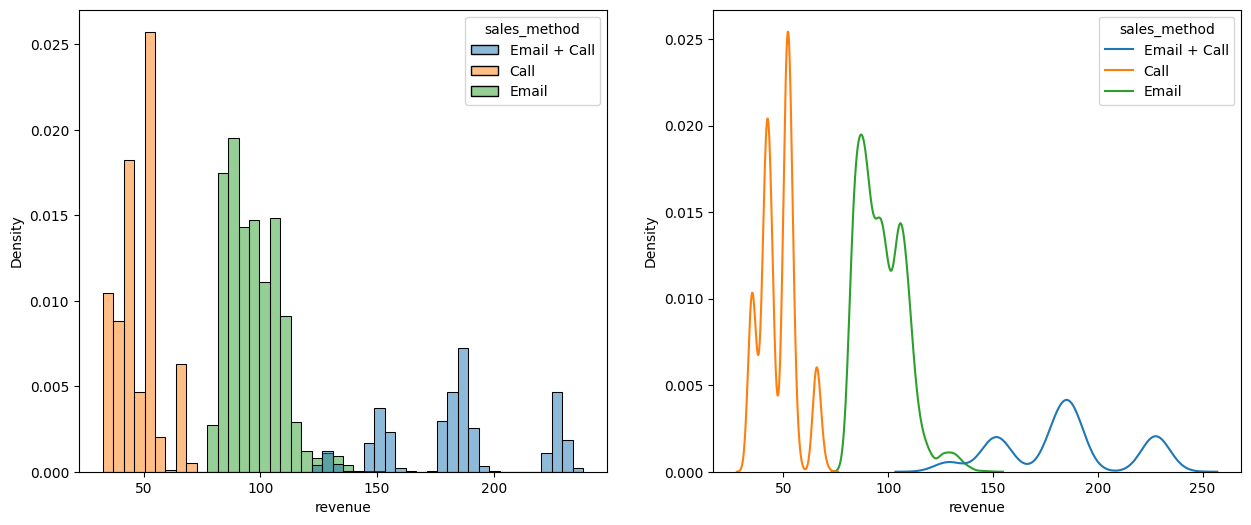

In [16]:
# Create 2x2 sub plots
gs = gridspec.GridSpec(1, 2)

# Create a figure
plt.figure(figsize=(15,6))

# add axes_1 row 0, col 0
ax1 = plt.subplot(gs[0, 0]) 
ax1 = sns.histplot(
    data=no_missing_data
    ,x='revenue'
    ,hue='sales_method'
    ,stat='density'
)

# add axes_2 row 0, col 1
ax2 = plt.subplot(gs[0, 1]) 
ax2 = sns.kdeplot(
    data=no_missing_data
    ,x='revenue'
    ,hue='sales_method'
)

# display plot
plt.show()


From the distribution of revenue of the non missing data for each of the sales method, we can be certain that it splitted into 3 very different groups across 3 sales methods. Based on this, we can impute data differently depending on which sales method

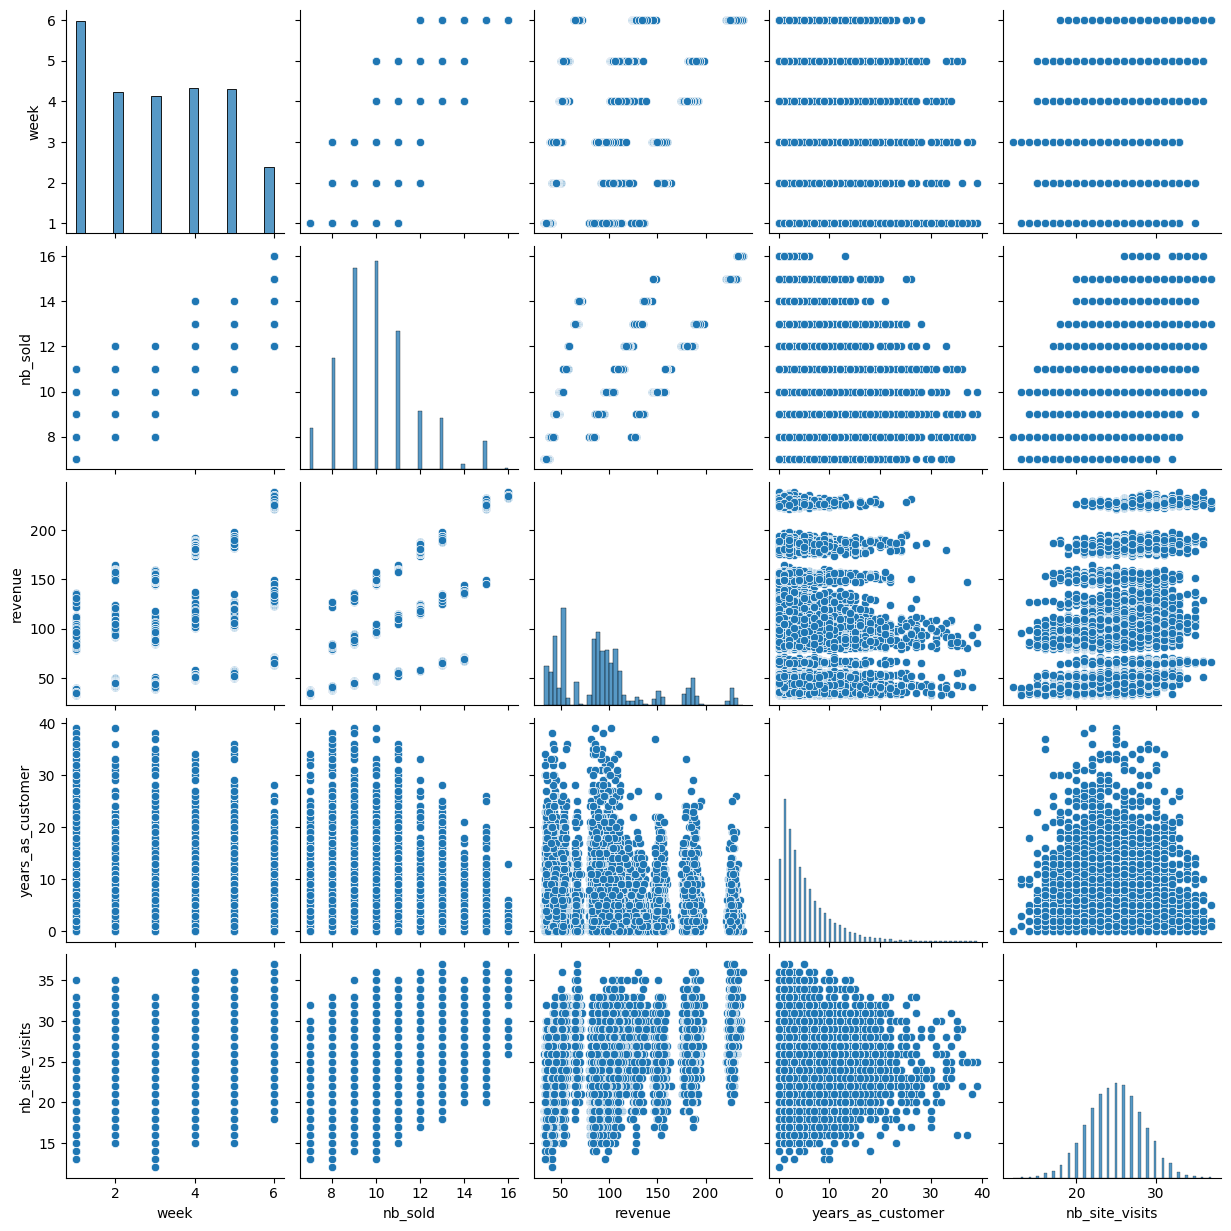

In [17]:
sns.pairplot(
    data=no_missing_data
    # ,vars=['revenue','nb_sold','sm_numeric']
)

And from the pairplot the revenue seems to have linear relationship with the nb_sold and the week variables. 

So I am going to do Data Imputation with Linear Regression on the missing data on revenue variable.

#### <a id='toc2_1_4_2_'></a>[Missing Data Handling with Regression Imputation | Linear Interpolation](#toc0_)

##### <a id='toc2_1_4_2_1_'></a>[Grouping data](#toc0_)

In [ ]:
email = no_missing_data[(no_missing_data.sales_method == 'Email')]
email_call = no_missing_data[(no_missing_data.sales_method == 'Email + Call')]
call = no_missing_data[(no_missing_data.sales_method == 'Call')]

##### <a id='toc2_1_4_2_2_'></a>[Checking for Statistical Significant Linear Relationship and Correlation Coefficient](#toc0_)

Dataset: Email

Spearman Correlation test between Revenue and Number of new product sold
- correlation coefficient: 0.9640167597896909
- p-value: 0.0
- alpha = 0.05, is p-value < alpha: True
Reject Ho, there is correlation between 2 variables



<Axes: >

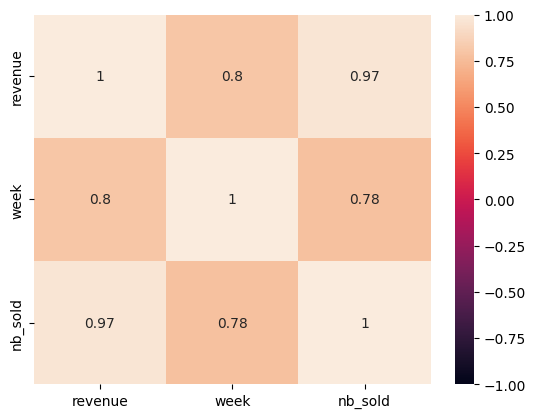

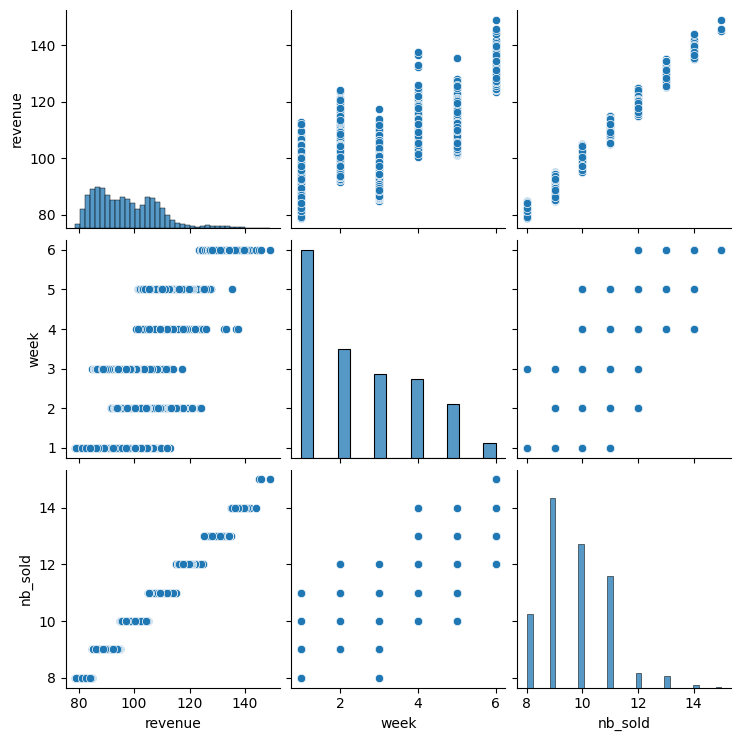




Dataset: Email + Call

Spearman Correlation test between Revenue and Number of new product sold
- correlation coefficient: 0.9671698990481201
- p-value: 0.0
- alpha = 0.05, is p-value < alpha: True
Reject Ho, there is correlation between 2 variables



<Axes: >

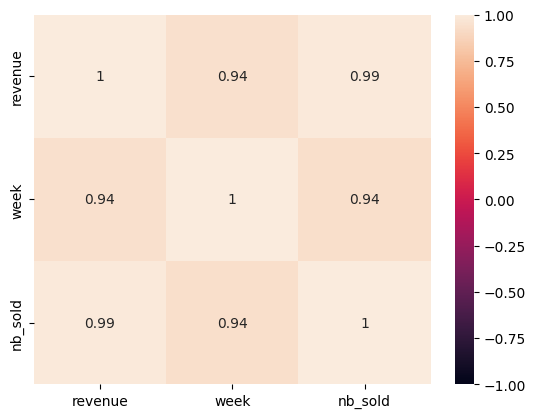

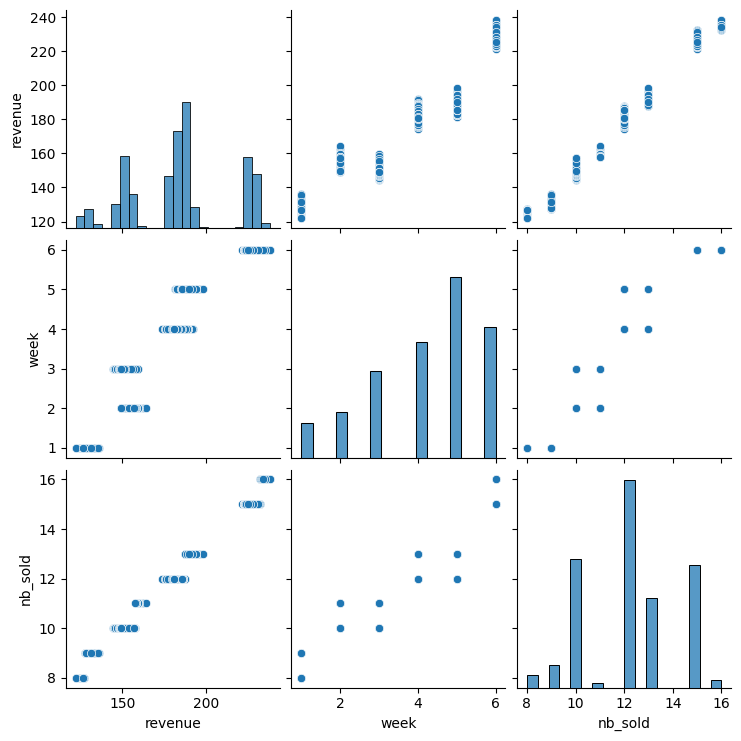




Dataset: Call

Spearman Correlation test between Revenue and Number of new product sold
- correlation coefficient: 0.9833106636480367
- p-value: 0.0
- alpha = 0.05, is p-value < alpha: True
Reject Ho, there is correlation between 2 variables



<Axes: >

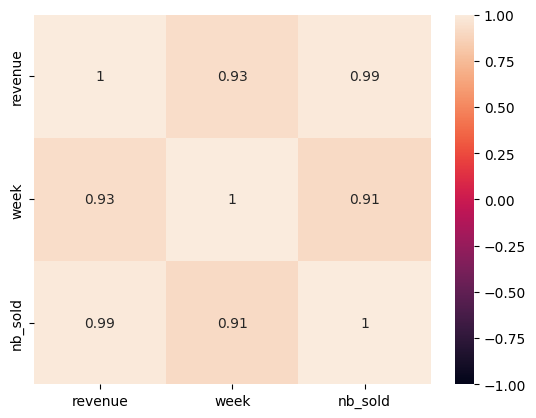

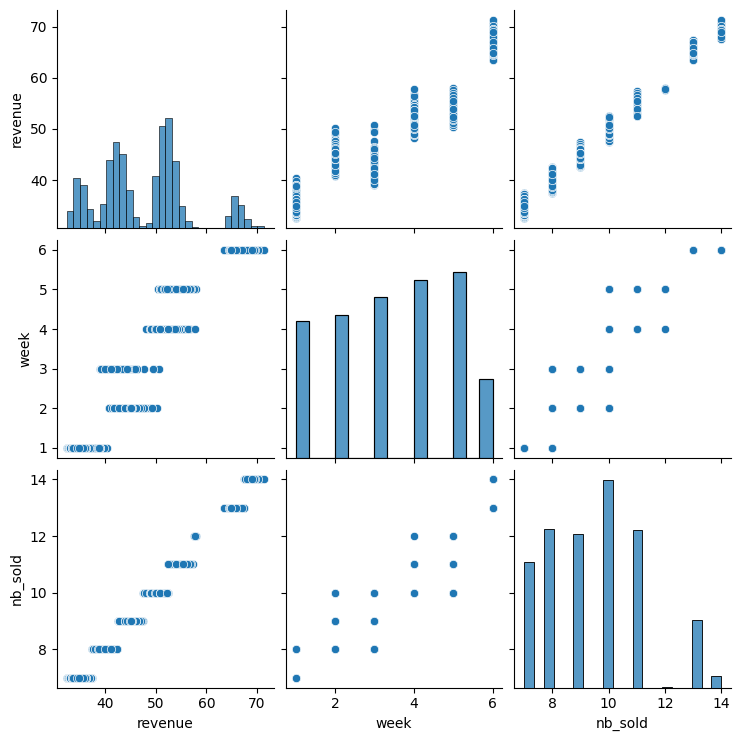

In [ ]:
for i in [email,email_call,call]:
    print(f'Dataset: {i.sales_method.unique()[0]}\n')
    
    print(f'Spearman Correlation test between Revenue and Number of new product sold')
    res = spearmanr(i.revenue, i.nb_sold)
    print(f'- correlation coefficient: {res.statistic}')
    print(f'- p-value: {res.pvalue}')
    print(f'- alpha = 0.05, is p-value < alpha: {res.pvalue < 0.05}')
    if res.pvalue < 0.05:
        print('Reject Ho, there is correlation between 2 variables\n')
    else:
        print('Fail to reject Ho, there is no correlation.\n')

    sns.heatmap(i[['revenue','week','nb_sold']].corr(numeric_only=True), annot=True, vmin=-1, vmax=1)
    sns.pairplot(i[['revenue','week','nb_sold']])
    plt.show()
    print(f'\n\n')

##### <a id='toc2_1_4_2_3_'></a>[Data Imputation with Linear Regression](#toc0_)

In [1]:
email = product_sales[(product_sales.sales_method == 'Email')]
email_call = product_sales[(product_sales.sales_method == 'Email + Call')]
call = product_sales[(product_sales.sales_method == 'Call')]

NameError: name 'product_sales' is not defined

In [ ]:
patch = pd.DataFrame(columns=['week','nb_sold','revenue'])

for i in [email,email_call,call]:
    print(i.sales_method.unique()[0],'dataset')
    i = i[['week','nb_sold','revenue']]
    X_target = i[i['revenue'].isna()].drop(columns='revenue')
    i = i[~i['revenue'].isna()]

    # splitting data
    X = i.drop(columns='revenue').values
    Y = i['revenue'].values
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3, random_state=24)
    
    # generating regression model
    model = linear_model.LinearRegression()
    model.fit(X_train,Y_train)
    Y_pred = model.predict(X_test)

    # evaluating prediction score
    print(f'r2 score: {round(r2_score(Y_test,Y_pred),4)}, meaning our models is capable to explain {100 * round(r2_score(Y_test,Y_pred),4)}% of the variance of data. This score is near perfect, lets apply to the missing values.')
    print(f'RMSE: {round(root_mean_squared_error(Y_test,Y_pred),2)}, equals to difference in difference between values = error of prediction')
    print(f'MAE: {round(mean_absolute_error(Y_test,Y_pred),2)}\n\n')


    # predicting missing value
    missing_data = X_target.values
    Y_target = model.predict(missing_data)
    X_target['revenue'] = Y_target
    X_target['revenue'] = X_target['revenue'].apply(lambda x: round(x,2))
    
    patch = pd.concat([patch,X_target])

# missing data imputation   
missing_data = product_sales[product_sales['revenue'].isna()].drop(columns='revenue')
missing_data = missing_data.merge(patch[['revenue']],how='inner',left_index=True,right_index=True)
product_sales = product_sales[~product_sales['revenue'].isna()]
product_sales = pd.concat([product_sales,missing_data])
product_sales = product_sales.sort_index(ascending=True)
print('after imputation')
product_sales.head()

Email dataset


LinearRegression()

r2 score: 0.9444, meaning our models is capable to explain 94.44% of the variance of data. This score is near perfect, lets apply to the missing values.
RMSE: 2.63, equals to difference in difference between values = error of prediction
MAE: 2.24


Email + Call dataset


C:\Users\Hung\AppData\Local\Temp\ipykernel_20636\933360212.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  patch = pd.concat([patch,X_target])


LinearRegression()

r2 score: 0.9817, meaning our models is capable to explain 98.17% of the variance of data. This score is near perfect, lets apply to the missing values.
RMSE: 3.99, equals to difference in difference between values = error of prediction
MAE: 3.34


Call dataset


LinearRegression()

r2 score: 0.9775, meaning our models is capable to explain 97.75% of the variance of data. This score is near perfect, lets apply to the missing values.
RMSE: 1.29, equals to difference in difference between values = error of prediction
MAE: 1.06


after imputation


,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state
0,2,Email,2e72d641-95ac-497b-bbf8-4861764a7097,10,98.97,0,24,Arizona
1,6,Email + Call,3998a98d-70f5-44f7-942e-789bb8ad2fe7,15,225.47,1,28,Kansas
2,5,Call,d1de9884-8059-4065-b10f-86eef57e4a44,11,52.55,6,26,Wisconsin
3,4,Email,78aa75a4-ffeb-4817-b1d0-2f030783c5d7,11,109.16,3,25,Indiana
4,3,Email,10e6d446-10a5-42e5-8210-1b5438f70922,9,90.49,0,28,Illinois


In [ ]:
print('Checking number of missing data:')
product_sales.isna().sum()

Checking number of missing data:


week                 0
sales_method         0
customer_id          0
nb_sold              0
revenue              0
years_as_customer    0
nb_site_visits       0
state                0
dtype: int64

# <a id='toc3_'></a>[II. Exploratory Analysis](#toc0_)
  - Include two different graphics showing single variables only to demonstrate the characteristics of data  
  - Include at least one graphic showing two or more variables to represent the relationship between features
  - Describe your findings

### <a id='toc3_1_1_'></a>[How many customers were there for each approach?](#toc0_)

In [21]:
q2 = product_sales.groupby('sales_method')['customer_id'].count().reset_index()
q2.rename(columns={'customer_id':'total_customer'},inplace=True)
q2


,sales_method,total_customer
0,Call,4961
1,Email,7465
2,Email + Call,2572


<Figure size 1500x600 with 0 Axes>

<Axes: xlabel='sales_method', ylabel='total_customer'>

[Text(0, 0, '2572')]

[Text(0, 0, '4961')]

[Text(0, 0, '7465')]

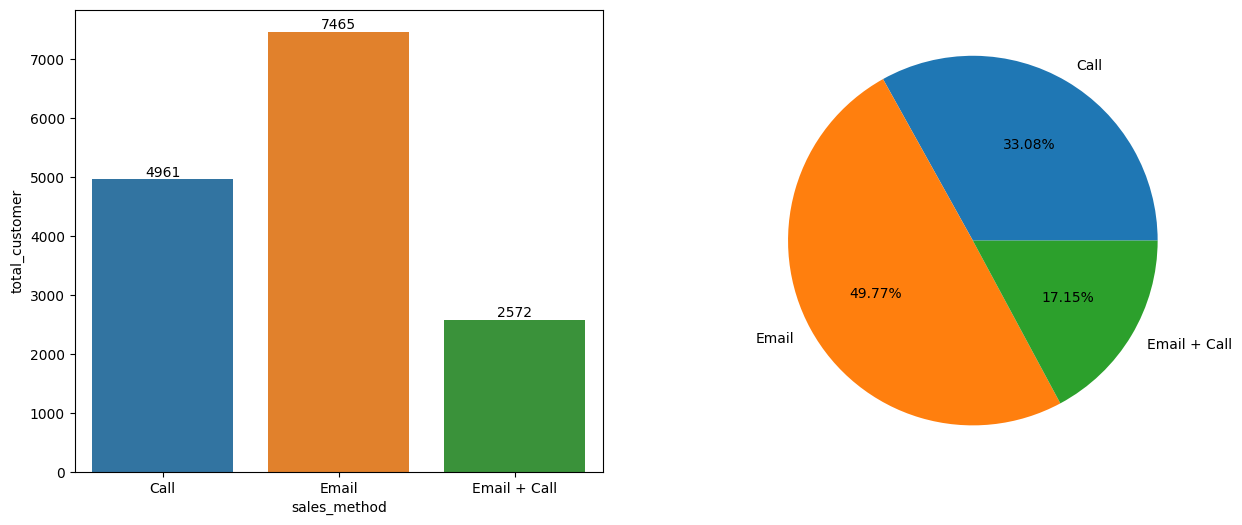

In [22]:
# Create 2x2 sub plots
gs = gridspec.GridSpec(1, 2)

# Create a figure
plt.figure(figsize=(15,6))

# add axes_1 row 0, col 0
ax1 = plt.subplot(gs[0, 0]) 
sns.barplot(
    data=q2
    ,x='sales_method'
    ,y='total_customer'
    ,hue='sales_method'
    ,ax=ax1
)

# add the annotation
ax1.bar_label(ax1.containers[-1], fmt='%.0f', label_type='edge')
ax1.bar_label(ax1.containers[0], fmt='%.0f', label_type='edge')
ax1.bar_label(ax1.containers[1], fmt='%.0f', label_type='edge')

# add axes_2 row 0, col 1
ax2 = plt.subplot(gs[0, 1]) 
ax2 = plt.pie(
    data=q2
    ,x='total_customer'
    ,labels='sales_method'
    ,autopct='%.2f%%'
)

# display plot
plt.show()

It is clear that Email method has 7466 customers which is the highest number of customer of all three methods, accounting for nearly half of the total number of customers. Followed by Call method with 4962 customers taking one third of the total revenue and closely around 2 times the number of customer of the Email and Call method which is the least one, exactly has 2572 customers and is 17.15% of the total number.

### <a id='toc3_1_2_'></a>[What does the spread of the revenue look like overall? And for each method?](#toc0_)

<Figure size 1000x1200 with 0 Axes>

Text(0.5, 1.0, 'Overall Distribution of Revenue')

Text(0.5, 1.0, 'Revenue distributed by each Sales Methods')

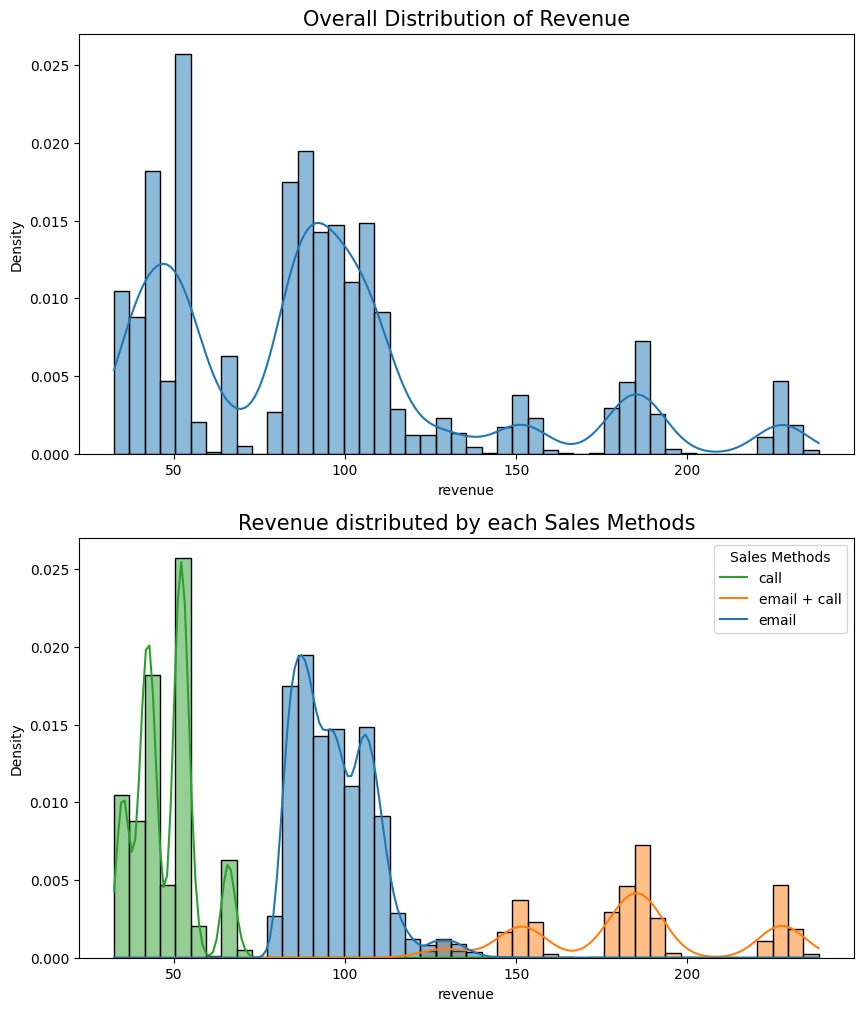

In [23]:
# Create 2x1 sub plots
gs = gridspec.GridSpec(2, 1)

# Create a figure
plt.figure(figsize=(10,12))

# add axes_1 row 0, col 0
ax1 = plt.subplot(gs[0, 0]) 
ax1 = sns.histplot(
    data=product_sales
    ,x='revenue'
    ,stat='density'
    ,kde=True
)
plt.title('Overall Distribution of Revenue',fontsize=15)

# add axes_2 row 1, col 0
ax2 = plt.subplot(gs[1, 0]) 
ax2 = sns.histplot(
    data=product_sales
    ,x='revenue'
    ,hue='sales_method'
    ,stat='density'
    ,kde=True
    
)
plt.legend(title='Sales Methods',labels=['call','email + call','email'])

plt.title('Revenue distributed by each Sales Methods',fontsize=15)
# display plot
plt.show()


In [24]:
product_sales.revenue.describe()

count    13924.000000
mean        93.937828
std         47.437281
min         32.540000
25%         52.470000
50%         89.500000
75%        107.330000
max        238.320000
Name: revenue, dtype: float64

Overall, our Revenue is very uneven distributed, is a Positive Skew or a Right Skew with long right tail. It can be splitted into 3 groups by different sales methods.

<Figure size 1600x1200 with 0 Axes>

Text(0.5, 1.0, 'Revenue distributed by each Sales Methods')

Text(0.5, 1.0, 'Distribution of Revenue of Call Method')

Text(0.5, 1.0, 'Distribution of Revenue of Email Method')

Text(0.5, 1.0, 'Distribution of Revenue of both Email and Call Method')

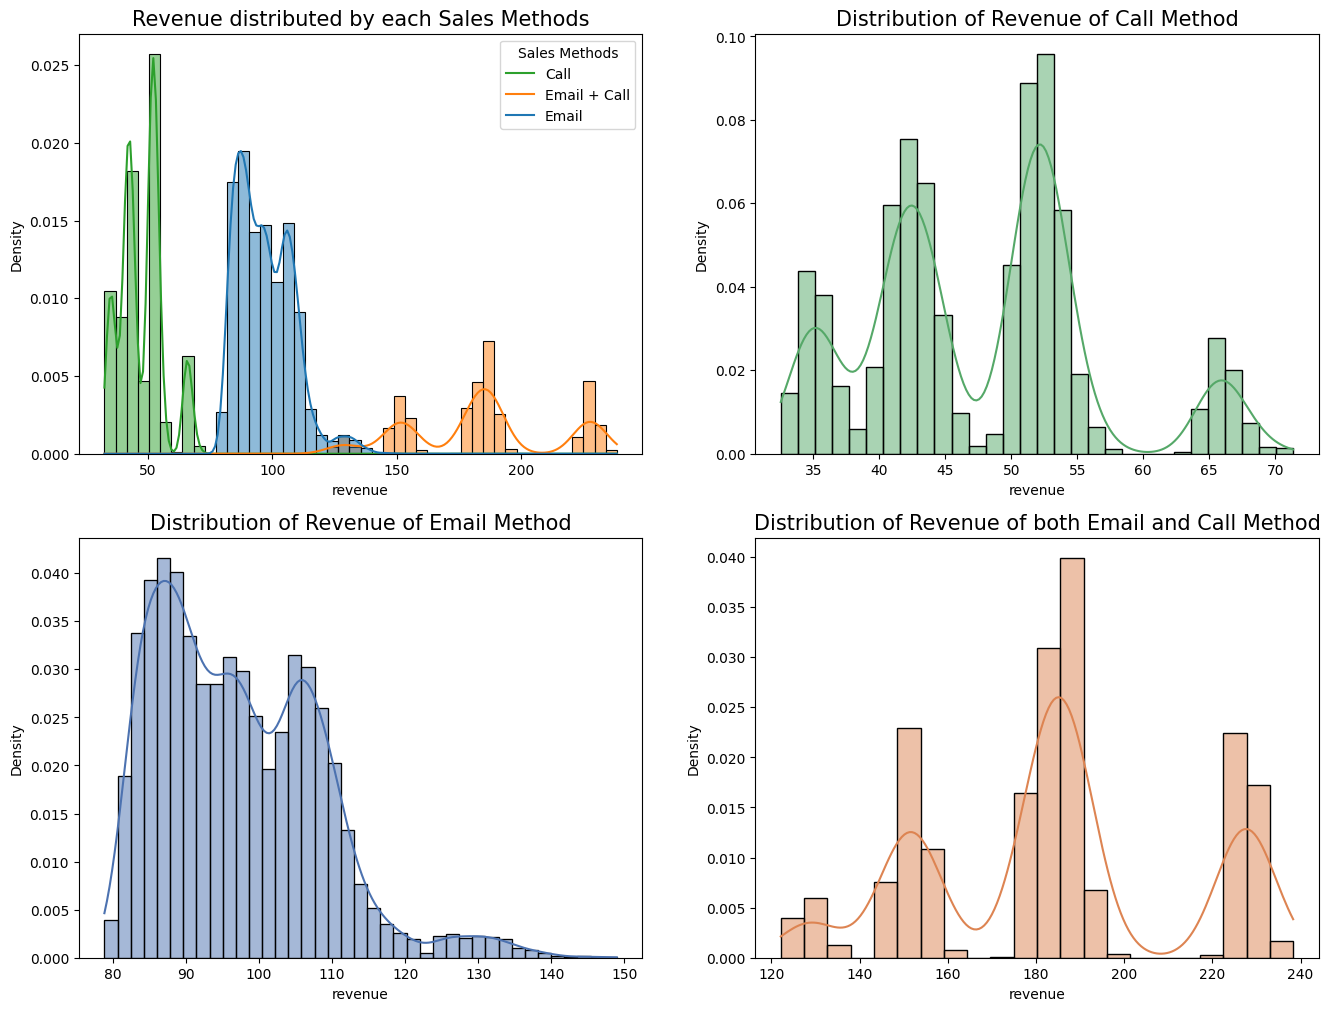

In [25]:
# Create 2x2 sub plots
gs = gridspec.GridSpec(2, 2)

# Create a figure
plt.figure(figsize=(16,12))

# add axes_1 row 0, col 0
ax1 = plt.subplot(gs[0, 0]) 
ax1 = sns.histplot(
    data=product_sales
    ,x='revenue'
    ,hue='sales_method'
    ,stat='density'
    ,kde=True
)
plt.legend(title='Sales Methods',labels=['Call','Email + Call','Email'])
plt.title('Revenue distributed by each Sales Methods',fontsize=15)

# add axes_2 row 0, col 1
ax2 = plt.subplot(gs[0, 1]) 
ax2 = sns.histplot(
    data=product_sales[product_sales.sales_method == 'Call']
    ,x='revenue'
    ,stat='density'
    ,kde=True
    ,color='#55a868'
)
plt.title('Distribution of Revenue of Call Method',fontsize=15)

# add axes_3 row 1, col 0
ax3 = plt.subplot(gs[1, 0]) 
ax3 = sns.histplot(
    data=product_sales[product_sales.sales_method == 'Email']
    ,x='revenue'
    ,stat='density'
    ,kde=True
    ,color='#4c72b0'
)
plt.title('Distribution of Revenue of Email Method',fontsize=15)

# add axes_4 row 1, col 1
ax4 = plt.subplot(gs[1, 1]) 
ax4 = sns.histplot(
    data=product_sales[product_sales.sales_method == 'Email + Call']
    ,x='revenue'
    ,stat='density'
    ,kde=True
    ,color='#dd8452'
)
plt.title('Distribution of Revenue of both Email and Call Method',fontsize=15)

# display plot
plt.show()

In [26]:
product_sales.groupby('sales_method')['revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
sales_method,,,,,,,,
Call,4780.0,47.596866,8.610699,32.54,41.470,49.05,52.68,71.36
Email,6921.0,97.127671,11.211279,78.83,87.880,95.58,105.17,148.97
Email + Call,2223.0,183.651233,29.083924,122.11,155.775,184.74,191.11,238.32


Revenue is distributed differently into 3 groups regarding to 3 sales methods:
- call only group: 
    + Negative Skew with its Mean value is less than Median value
    + ranging from 32.54 to 71.36
    + can be broken down into 4 smaller groups
    + Smallest std, Least spread out
- email only group: 
    + Positive Skew with its Mean is more than Median
    + ranging from 78.83 to 148.97
- email and call group:
    + Symmetrical Distributed with its Mean closely equals to Median
    + ranging from 120.84 to 238.32
    + can be broken down into 4 smaller groups
    + Largest std, Most spread out

### <a id='toc3_1_3_'></a>[Was there any difference in revenue over time for each of the methods?](#toc0_)

<Figure size 1500x600 with 0 Axes>

Text(0.5, 1.0, 'Total revenue over weeks for each sales methods')

Text(0.5, 0, 'week')

Text(0, 0.5, 'revenue')

Text(0.5, 1.0, 'Total revenue trends over weeks breakdown by each sales methods')

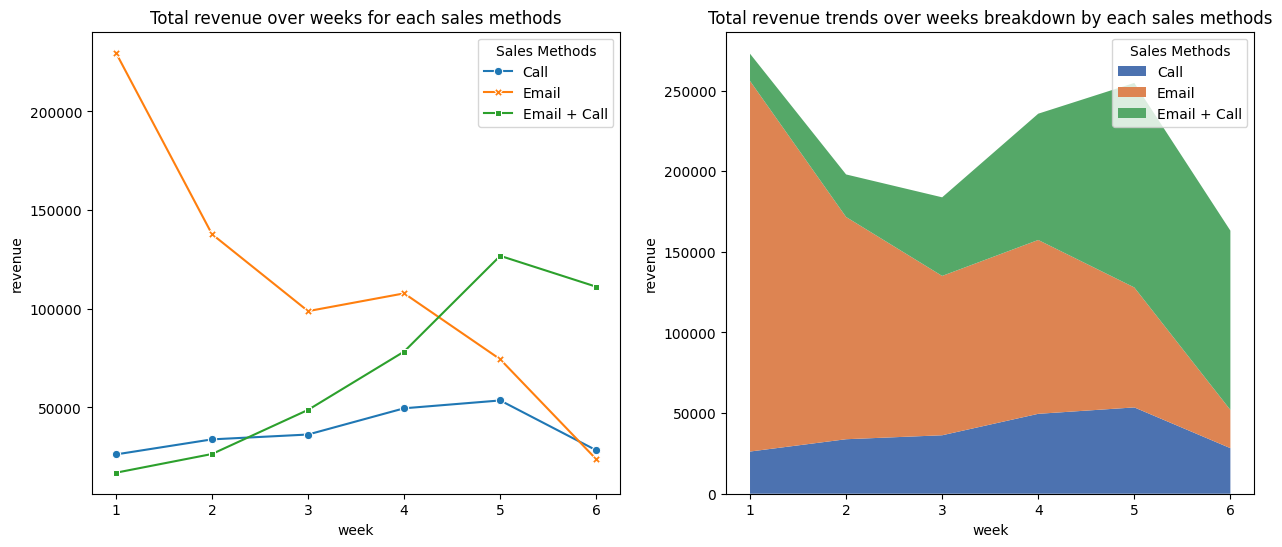

In [27]:
aggregation = product_sales.groupby(['sales_method','week']).agg({
    'customer_id':'count'
    ,'revenue':'sum'
}).rename(columns={'customer_id':'number_of_customer'}).reset_index()

aggregation_pivot = aggregation.pivot(
    index='week'
    ,columns='sales_method'
    ,values='revenue'
).reset_index()

# Create 2x2 sub plots
gs = gridspec.GridSpec(1, 2)

# Create a figure
plt.figure(figsize=(15,6))

# add axes_1 row 0, col 0
ax1 = plt.subplot(gs[0, 0]) 
ax1 = sns.lineplot(
    data=aggregation
    ,x='week'
    ,y='revenue'
    ,hue='sales_method'
    ,style='sales_method'
    ,markers=True
    ,dashes=False
)
plt.legend(title='Sales Methods')
plt.title('Total revenue over weeks for each sales methods')

# add axes_2 row 0, col 1
ax2 = plt.subplot(gs[0, 1]) 
ax2 = plt.stackplot(
    aggregation_pivot['week']
    ,aggregation_pivot['Call']
    ,aggregation_pivot['Email']
    ,aggregation_pivot['Email + Call']
    ,labels=['Call', 'Email', 'Email + Call']
    ,colors=['#4c72b0', '#dd8452', '#55a868'] 
)

plt.legend(title='Sales Methods')
plt.xlabel('week')
plt.ylabel('revenue')
plt.title('Total revenue trends over weeks breakdown by each sales methods')

# display plot
plt.show()


In [ ]:
import plotly.express as px
# sns.set_theme()
px.scatter(aggregation_pivot
                      , x = 'week'
                      , y = ['Call', 'Email', 'Email + Call']
                      , trendline = 'ols'
                      , width = 1000
                      , height = 600
                      , title = 'Revenue Trends of each sales methods'
)

plt.show()

#### <a id='toc3_1_3_1_'></a>[Conclusion](#toc0_)

- Email method: 
    + has the highest initial revenue, nearly 230k 
    + has the lowest final revenue, 23.7k
    + has the negative revenue trend (revenue decrease sharply through time)

- Email + Call method:
    + has the lowest initial revenue, around 16.8k
    + has the highest final revenue, 111.1k
    + has the positive revenue trend (revenue increase sharply through time)

- Call method:
    + has low initial at 26.1k & final revenue 28.25k
    + revenue trend remain the same

# <a id='toc4_'></a>[III. Prediction Analysis](#toc0_)

### <a id='toc4_1_1_'></a>[Predicted Total Revenue](#toc0_)

In [29]:
import pandas as pd
emp_df = pd.DataFrame({'week':[7,8,9,10]})
# total revenue
for col in ['Call', 'Email', 'Email + Call']:

# create week 7,8,9,10
    x = np.array([7,8,9,10]).reshape(-1, 1)

# generating regression model
    model = linear_model.LinearRegression()
    model.fit(
        X = np.array(aggregation_pivot['week']).reshape(-1, 1)
        ,y = np.array(aggregation_pivot[col]).reshape(-1, 1)
    )

    pred_average_rev = model.predict(x)
    
    pred_df = pd.DataFrame({'week':x.reshape(-1), col:pred_average_rev.reshape(-1)})
    # pred_df = pd.concat([emp_df,pred_df])
    pred_df[col] = pred_df[col].apply(lambda x: 0 if x <= 0 else round(x,2))
    emp_df = emp_df.merge(pred_df,how='inner',on='week')
    
total_revenue = pd.concat([aggregation_pivot,emp_df])
# total_revenue

LinearRegression()

LinearRegression()

LinearRegression()

In [30]:
aggregation

,sales_method,week,number_of_customer,revenue
0,Call,1,758,26159.18
1,Call,2,805,33792.02
2,Call,3,902,36247.27
3,Call,4,1004,49543.52
4,Call,5,1044,53518.11
5,Call,6,448,28252.92
6,Email,1,2815,229765.55
7,Email,2,1485,137794.35
8,Email,3,1150,98792.14
9,Email,4,1075,107788.37


In [31]:
aggregation_pivot

sales_method,week,Call,Email,Email + Call
0,1,26159.18,229765.55,16885.33
1,2,33792.02,137794.35,26376.23
2,3,36247.27,98792.14,48737.14
3,4,49543.52,107788.37,78296.20
4,5,53518.11,74373.45,126809.72
5,6,28252.92,23706.75,111152.07


In [32]:
total_revenue

,week,Call,Email,Email + Call
0,1,26159.18,229765.55,16885.33
1,2,33792.02,137794.35,26376.23
2,3,36247.27,98792.14,48737.14
3,4,49543.52,107788.37,78296.20
4,5,53518.11,74373.45,126809.72
5,6,28252.92,23706.75,111152.07
0,7,46213.16,0.00,148262.10
1,8,48582.96,0.00,171181.91
2,9,50952.77,0.00,194101.72
3,10,53322.58,0.00,217021.52


In [ ]:

# plot the predicted values    
px.scatter(total_revenue
                      , x = 'week'
                      , y = ['Call', 'Email', 'Email + Call']
                      , trendline = 'ols'
                      , width = 1000
                      , height = 600
                      , title = 'Predicted Revenue of each sales methods'
).update_layout(
    yaxis_title="Total Revenue"
)
plt.show()

### <a id='toc4_1_2_'></a>[Predicted Cumulative revenue](#toc0_)

In [34]:
accumulate_revenue = pd.get_dummies(total_revenue)

for i in ['Call','Email','Email + Call']:
    accumulate_revenue[i] = accumulate_revenue[i].cumsum()
accumulate_revenue

,week,Call,Email,Email + Call
0,1,26159.18,229765.55,16885.33
1,2,59951.20,367559.90,43261.56
2,3,96198.47,466352.04,91998.70
3,4,145741.99,574140.41,170294.90
4,5,199260.10,648513.86,297104.62
5,6,227513.02,672220.61,408256.69
0,7,273726.18,672220.61,556518.79
1,8,322309.14,672220.61,727700.70
2,9,373261.91,672220.61,921802.42
3,10,426584.49,672220.61,1138823.94


In [ ]:
# plot the predicted values    
px.scatter(accumulate_revenue
                      , x = 'week'
                      , y = ['Call', 'Email', 'Email + Call']
                      , trendline = 'ols'
                      , width = 1000
                      , height = 600
                      , title = 'Predicted Accumulative Revenue of each sales methods'
).update_layout(
    yaxis_title="Accumulative Revenue"
)
plt.show()


### <a id='toc4_1_3_'></a>[Conclusion](#toc0_)

- According to the current revenue trend
    + Email method:
        + Total Revenue per week: there will be no new revenue for the following week
        + Because it is predicted to not be able to generate new revenue, the accumlated revenue of the following weeks will be the same as the week 6, staying at around 672.3k
    + Call method:
        + Total Revenue per week: expected to rise to 46.2k at week 7 and a stable 2k - 3k increase per week
        + Accumulative Revenue per week: as predicted to have a stable and slightly increase per week, finally will reach 426.7k at week 10, however it is still the lowest accumulated revenue of all three of the methods.
    + Email + Call method:
        + Total Revenue per week: Has the sharpest increase in total revenue per week and is predicted to reach 217k at week 10
        + Accumulative Revenue per week: it is expected to be equal to Email method's somewhere at week 7 and surpass the accumulated revenue of the email method from week 7 onward, it will be around 1.13 mil at week 10. 

# <a id='toc5_'></a>[IV. New Metrics Recommendation](#toc0_)
- How should the business monitor what they want to achieve?
- Estimate the initial value(s) for the metric based on the current data?

### <a id='toc5_1_1_'></a>[ARPU & Revenue Growth Rate](#toc0_)

- ARPU:
    + Uses: Measures a company's success in scaling its business model
    + Measures performance per unit, as opposed to overall performance
    + Even if the overall revenue is increasing, if ARPU is decreasing, the company is less effective at generating revenue from each of its users. 
    + ARPU measures the average revenue generated per user or customer or sold products. $$\frac{Total\ Revenue}{ Total\ Number\ Of\ Users }$$

- Revenue growth rate 
    + Revenue growth refers to the increase in a company’s total revenue or income over a specific period, typically calculated quarterly or annually, in this case, we will use weekly revenue growth.
    + $$\frac{current\ period’s\ revenue - previous\ period’s\ revenue}{previous\ period’s\ revenue} * 100$$

In [36]:
sns.set_theme()

aggregation = product_sales.groupby('sales_method').agg({
    'customer_id':'count'
    ,'revenue':'sum'
}).rename(columns={'customer_id':'number_of_customer'})
aggregation['average_revenue_per_customer'] = aggregation['revenue'] / aggregation['number_of_customer']

q4 = product_sales.groupby(['sales_method','week']).agg({
    'customer_id':'count'
    ,'revenue':'sum'
    ,'nb_sold':'sum'
}).rename(columns={'customer_id':'number_of_customer','nb_sold':'number_of_new_product_sold'})
q4['average_revenue_per_customer'] = q4['revenue'] / q4['number_of_customer']
q4['average_revenue_per_unit'] = q4['revenue'] / q4['number_of_new_product_sold']
q4.reset_index(drop=False,inplace=True)

call = q4[q4.sales_method == 'Call']
call['revenue_growth_rate'] = call['revenue'].pct_change(periods=1) * 100

email = q4[q4.sales_method == 'Email']
email['revenue_growth_rate'] = email['revenue'].pct_change(periods=1) * 100

email_call = q4[q4.sales_method == 'Email + Call']
email_call['revenue_growth_rate'] = email_call['revenue'].pct_change(periods=1) * 100

q4 = pd.concat([call,email,email_call]).fillna(0)

<Figure size 1500x1100 with 0 Axes>

[Text(0, 0, '45.8603')]

[Text(0, 0, '90.0496')]

[Text(0, 0, '158.731')]

Text(0, 0.5, 'ARPU')

Text(0.5, 0, 'Sales Methods')

Text(0.5, 1.0, 'Overall Average Revenue per Customer by Sales Methods')

Text(0, 0.5, 'ARPU')

Text(0.5, 1.0, 'Weekly Average Revenue per Customer by Sales Methods')

Text(0, 0.5, 'Revenue Growth Rate')

Text(0.5, 1.0, 'Weekly Revenue Growth Rate by Sales Methods')

Text(0.5, 1.0, 'Weekly Average Revenue per Sold New Products by Sales Methods')

Text(0, 0.5, 'Average Revenue Per Sold New Products')

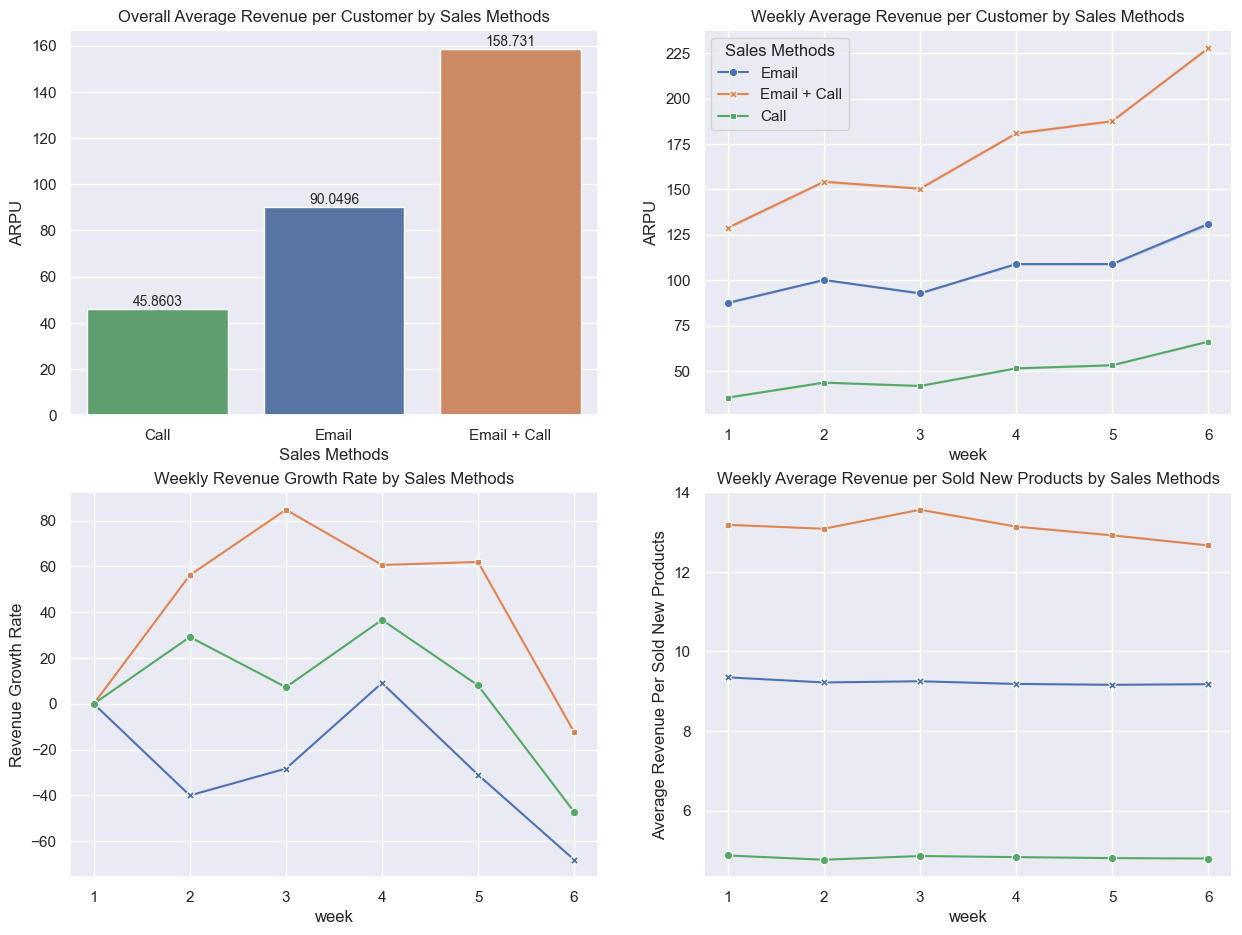

In [37]:

# Create 2x2 sub plots
gs = gridspec.GridSpec(2, 2)

# Create a figure
plt.figure(figsize=(15,11))

# add axes_1 row 0, col 0
ax1 = plt.subplot(gs[0, 0]) 
ax1 = sns.barplot(
    data=aggregation
    ,x='sales_method'
    ,y='average_revenue_per_customer'
    ,hue='sales_method'
    ,hue_order=['Email','Email + Call','Call']
)

# add annotations to each bar
ax1.bar_label(ax1.containers[-1], fontsize=10)
ax1.bar_label(ax1.containers[0], fontsize=10)
ax1.bar_label(ax1.containers[1], fontsize=10)

# add labels and titles
plt.ylabel('ARPU')
plt.xlabel('Sales Methods')
plt.title('Overall Average Revenue per Customer by Sales Methods')

# add axes_2 row 0, col 1
ax2 = plt.subplot(gs[0, 1]) 
ax2 = sns.lineplot(
    data=product_sales
    ,x='week'
    ,y='revenue'
    ,hue='sales_method'
    ,style='sales_method'
    ,markers=True
    ,dashes=False
)

# add labels and titles
plt.ylabel('ARPU')
plt.title('Weekly Average Revenue per Customer by Sales Methods')
plt.legend(title='Sales Methods')

# add axes_3 row 1, col 0
ax3 = plt.subplot(gs[1, 0]) 
ax3 = sns.lineplot(
    data=q4
    ,x='week'
    ,y='revenue_growth_rate'
    ,hue='sales_method'
    ,style='sales_method'
    ,markers=True
    ,dashes=False
    ,hue_order=['Email','Email + Call','Call']
    ,legend=False
)
plt.ylabel('Revenue Growth Rate')
plt.title('Weekly Revenue Growth Rate by Sales Methods')

# add axes_4 row 1, col 1
ax4 = plt.subplot(gs[1, 1]) 
ax4 = sns.lineplot(
    data=q4
    ,x='week'
    ,y='average_revenue_per_unit'
    ,hue='sales_method'
    ,style='sales_method'
    ,markers=True
    ,dashes=False
    ,hue_order=['Email','Email + Call','Call']
    ,legend=False
)
ax4.set_title('Weekly Average Revenue per Sold New Products by Sales Methods')
ax4.set_ylabel('Average Revenue Per Sold New Products')

# display plot
plt.show()

- Email + Call method:
    + has the highest ARPU (almost double the Email's ARPU)
    + has the highest Revenue Growth Rate (mostly positive)
- Email method: 
    + has the average ARPU (almost double the Call's ARPU)
    + has the lowest Revenue Growth Rate (mostly negative)
- Call method:
    + has the lowest ARPU 
    + has a high Revenue Growth Rate but is lower than Email + Call method's in every weeks

### <a id='toc5_1_2_'></a>[Predicted ARPU & Revenue Growth Rate](#toc0_)

##### <a id='toc5_1_2_1_1_'></a>[ARPU](#toc0_)

In [38]:
ARPU = q4[['sales_method','week','average_revenue_per_customer']].pivot(
    index='week'
    ,columns='sales_method'
    ,values='average_revenue_per_customer'
).reset_index()


In [39]:
px.scatter(ARPU
                      , x = 'week'
                      , y = ['Call', 'Email', 'Email + Call']
                      , trendline = 'ols'
                      , width = 1000
                      , height = 600
                      , title = 'Current Average Revenue Per User Trends of each sales methods'
).update_layout(
    yaxis_title="ARPU"
)
plt.show()

In [40]:
emp_df = pd.DataFrame({'week':[7,8,9,10]})
# total revenue
for col in ['Call', 'Email', 'Email + Call']:

# create week 7,8,9,10
    x = np.array([7,8,9,10]).reshape(-1, 1)

# generating regression model
    model = linear_model.LinearRegression()
    model.fit(
        X = np.array(ARPU['week']).reshape(-1, 1)
        ,y = np.array(ARPU[col]).reshape(-1, 1)
    )

    pred_gr = model.predict(x)
    
    pred_df = pd.DataFrame({'week':x.reshape(-1), col:pred_gr.reshape(-1)})
    emp_df = emp_df.merge(pred_df,how='inner',on='week')
    
pred_average_rev = pd.concat([ARPU,emp_df])
pred_average_rev = pred_average_rev.apply(lambda x: round(x,2))
pred_average_rev

LinearRegression()

LinearRegression()

LinearRegression()

,week,Call,Email,Email + Call
0,1,34.51,81.62,114.09
1,2,41.98,92.79,131.88
2,3,40.19,85.91,135.76
3,4,49.35,100.27,158.17
4,5,51.26,100.10,161.13
5,6,63.06,120.34,190.66
0,7,64.70,119.82,197.91
1,8,69.84,126.39,212.00
2,9,74.98,132.96,226.08
3,10,80.11,139.53,240.17


In [41]:
# plot the predicted values    
px.scatter(pred_average_rev
                      , x = 'week'
                      , y = ['Call', 'Email', 'Email + Call']
                      , trendline = 'ols'
                      , width = 1000
                      , height = 600
                      , title = 'Predicted ARPU of each sales methods'
).update_layout(
    yaxis_title="Predicted Average Revenue Per User"
)
plt.show()

In [ ]:
long_arpu = pd.melt(
    frame=pred_average_rev
    ,id_vars=['week']
    ,value_vars=['Call','Email','Email + Call']
    ,var_name='sales_method'
    ,value_name='arpu'
)
long_arpu

,week,sales_method,arpu
0,1,Call,34.51
1,2,Call,41.98
2,3,Call,40.19
3,4,Call,49.35
4,5,Call,51.26
5,6,Call,63.06
6,7,Call,64.70
7,8,Call,69.84
8,9,Call,74.98
9,10,Call,80.11


##### <a id='toc5_1_2_1_2_'></a>[Growth Rate](#toc0_)

In [43]:
GR = q4[['sales_method','week','revenue_growth_rate']].pivot(
    index='week'
    ,columns='sales_method'
    ,values='revenue_growth_rate'
).reset_index()

In [44]:
px.scatter(GR
                      , x = 'week'
                      , y = ['Call', 'Email', 'Email + Call']
                      , trendline = 'ols'
                      , width = 1000
                      , height = 600
                      , title = 'Growth Rate of each sales methods'
).update_layout(
    yaxis_title="Growth Rate"
)
plt.show()

In [45]:
emp_df = pd.DataFrame({'week':[7,8,9,10]})
# total revenue
for col in ['Call', 'Email', 'Email + Call']:

# create week 7,8,9,10
    x = np.array([7,8,9,10]).reshape(-1, 1)

# generating regression model
    model = linear_model.LinearRegression()
    model.fit(
        X = np.array(GR['week']).reshape(-1, 1)
        ,y = np.array(GR[col]).reshape(-1, 1)
    )

    pred_gr = model.predict(x)
    
    pred_df = pd.DataFrame({'week':x.reshape(-1), col:pred_gr.reshape(-1)})
    emp_df = emp_df.merge(pred_df,how='inner',on='week')
    
pred_growth_rate = pd.concat([GR,emp_df])
pred_growth_rate = pred_growth_rate.apply(lambda x: round(x,2))
pred_growth_rate


LinearRegression()

LinearRegression()

LinearRegression()

,week,Call,Email,Email + Call
0,1,0.00,0.00,0.00
1,2,29.18,-40.03,56.21
2,3,7.27,-28.30,84.78
3,4,36.68,9.11,60.65
4,5,8.02,-31.00,61.96
5,6,-47.21,-68.12,-12.35
0,7,-21.35,-54.00,35.01
1,8,-29.07,-61.89,33.05
2,9,-36.79,-69.78,31.09
3,10,-44.50,-77.67,29.13


In [ ]:
# plot the predicted values    
px.scatter(pred_growth_rate
                      , x = 'week'
                      , y = ['Call', 'Email', 'Email + Call']
                      , trendline = 'ols'
                      , width = 1000
                      , height = 600
                      , title = 'Predicted Revenue Growth Rate of each sales methods'
).update_layout(
    yaxis_title="Predicted Revenue Growth Rate"
)
plt.show()

#### <a id='toc5_1_2_2_'></a>[Conclusion](#toc0_)

- Email + Call method:
    + Average Revenue Per User: initially and trendly highest. it is 114.09 and 240.17 at week 1 and week 10, respectively. 
    + Revenue Growth Rate: is the highest. it has the slightest downward trend. it is predicted to stay at 29.13% at week 10 which is genuinely positive percentage (the common ideally growth rate is around 20 to 25%)

- Email method:
    + Average Revenue Per User: is higher than Call's ARPU and lower than Email + Call's ARPU at every week. it goes from 81.62 to 139.53 at week 1 to week 10, respectively.
    + Revenue Growth Rate: is the lowest at every week. it is almost stay negative at every week. it is predicted to reach the lowest at week 10 at around -78% 

- Call method:
    + Average Revenue Per User: initially and overally lowest. it started at 34.51 at week 1 and is predicted to reach 80.11 at week 10
    + Revenue Growth Rate: stay positive in the early weeks, however from week 6 onwards it is predicted to be negative and had a downward trend. it reached the lowest at -44.5% at week 10.

# <a id='toc6_'></a>[V. Summary & Recommendation](#toc0_)
- Final summary including recommendations that the business should undertake

**1. Call Method:**
- Low initial revenue 26.15k 
- Low revenue growth rate, is predicted to be -44.5% at week 10
- Lowest average revenue per user: 
    + ARPU is overally at 45.86 
    + ARPU is weekly at 63 at week 6
- Lowest accumulative revenue: is predicted to be around 426.6k at week 10
- Conclusion: This is the worst sales method with the least of revenue and growth potential comparing to the other two methods.

**2. Email Method:**
- High initial revenue 229.7k
- Lowest revenue growth rate, is predicted to be -77% at week 10
- Low average revenue per user: 
    + ARPU is overally at 90 
    + ARPU is weekly at 120.33 at week 6
- Highest accumulative revenue in the earlier weeks from 229k at week 1 to 672k at week 6 then it is expected to stay at 672k to week 10. 
- Pros:
    + Immediate cash flow boost.
    + Quick return on investment.
    + Useful for short-term financial stability.
- Cons:
    + Limited long-term growth potential.
    + May not sustain business expansion.
    + Could lead to stagnation over time.

**3. Email and call method:**
- Low initial revenue 16.88k
- Highest revenue growth rate, is predicted to be 29.13% at week 10
- Highest average revenue per user: 
    + ARPU is overally at 158.7, is 76.3% and 246% higher than Email and Call methods, respectively
    + ARPU is weekly at 190.66 at week 6, is 58.44% and 202.6% higher than Email and Call methods, respectively
    + ARPU is predicted to reach 240.17 at week 10 
- Initially low accumulative revenue in the early weeks (408k at week 6), is predicted to cross Email's Accumulated Revenue at 672k at sometimes around week 7 to week 8 and finally reach the highest accumulative revenue point at week 10 around 1.13 Million which is the highest of all three methods
- Pros:
    + Potential for significant long-term growth.
    + Better scalability.
    + Can lead to higher overall revenue in the long run.
- Cons:
    + Requires patience and sustained investment.
    + Initial financial strain.
    + Riskier if growth projections are not met.

## <a id='toc6_1_'></a>[Recommendation](#toc0_)

Email method is only suitable for business in the early stages, looking for immediate cash flow to cover for the operational expense. 

Meanwhile, we, the Pens and Printers was founded in 1984 meaning we being running this business for almost 40 years, and we do business base on the trust and long lasting relationships with our customers. Now we launching a new product line which demands a strong customer base and rapid scaling then I suggest the Email + Call method is the most suitable way for this point forward.

Another point is that the Email + Call method has the highest and increasing ARPU overall and week-on-week, respectively, indicating that using this method, Pens and Printers is not only gaining sustainable revenue from time to time but also is getting more effective at generating revenue from each of it's users. Additionally, according to the Acumulative Revenue, at week 10 it is predicted that if we choose Call method we will lose 712,126.49 and if we choose to go with the Email method we will lose 466,506.11. 

Therefore, my recommendation is that as for the new product, we should only use the Email + Call method from this point forward for this product, then use:
- Total revenue and trends: to monitor the profitability and trends of the overall financial performance
- Average Revenue per Unit: to monitor the efficiency of gereneting revenue from each users | products
- Revenue Growth Rate: to monitor the potential for long-term growth, a good growth rate also attracts more investors. In most cases, an ideal growth rate will be around 15 and 25% annually.